In [1]:
import sys
import pdb
import pprint
import logging
import os
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import numpy as np
import tqdm.auto as tqdm
from pathlib import Path
from argparse import Namespace
from fairseq import utils
import sentencepiece as spm
import wandb

import matplotlib.pyplot as plt

## data extract

In [2]:
data_dir = 'data/translate/'

prefix = Path(data_dir).absolute()

src_lang = 'en'
tgt_lang = 'zh'

data_prefix = f'{prefix}/train_dev.raw'

## Preprocess files

In [3]:
import re

def strQ2B(ustring):
    """Full width -> half width"""
    # reference:https://ithelp.ithome.com.tw/articles/10233122
    ss = []
    for s in ustring:
        rstring = ""
        for uchar in s:
            inside_code = ord(uchar)
            if inside_code == 12288:  # Full width space: direct conversion
                inside_code = 32
            elif (inside_code >= 65281 and inside_code <= 65374):  # Full width chars (except space) conversion
                inside_code -= 65248
            rstring += chr(inside_code)
        ss.append(rstring)
    return ''.join(ss)
                
def clean_s(s, lang):
    if lang == 'en':
        s = re.sub(r"\([^()]*\)", "", s) # remove ([text])
        s = s.replace('-', '') # remove '-'
        s = re.sub('([.,;!?()\"])', r' \1 ', s) # keep punctuation
    elif lang == 'zh':
        s = strQ2B(s) # Q2B
        s = re.sub(r"\([^()]*\)", "", s) # remove ([text])
        s = s.replace(' ', '')
        s = s.replace('—', '')
        s = s.replace('“', '"')
        s = s.replace('”', '"')
        s = s.replace('_', '')
        s = re.sub('([。,;!?()\"~「」])', r' \1 ', s) # keep punctuation
    s = ' '.join(s.strip().split())
    return s

def len_s(s, lang):
    if lang == 'zh':
        return len(s)
    return len(s.split())

def clean_corpus(prefix, l1, l2, ratio=9, max_len=1000, min_len=1):
    if Path(f'{prefix}.clean.{l1}').exists() and Path(f'{prefix}.clean.{l2}').exists():
        print(f'{prefix}.clean.{l1} & {l2} exists. skipping clean.')
        return
    with open(f'{prefix}.{l1}', 'r', encoding='utf-8') as l1_in_f:
        with open(f'{prefix}.{l2}', 'r', encoding='utf-8') as l2_in_f:
            with open(f'{prefix}.clean.{l1}', 'w', encoding='utf-8') as l1_out_f:
                with open(f'{prefix}.clean.{l2}', 'w', encoding='utf-8') as l2_out_f:
                    for s1 in l1_in_f:
                        s1 = s1.strip()
                        s2 = l2_in_f.readline().strip()
                        s1 = clean_s(s1, l1)
                        s2 = clean_s(s2, l2)
                        s1_len = len_s(s1, l1)
                        s2_len = len_s(s2, l2)
                        if min_len > 0: # remove short sentence
                            if s1_len < min_len or s2_len < min_len:
                                continue
                        if max_len > 0: # remove long sentence
                            if s1_len > max_len or s2_len > max_len:
                                continue
                        if ratio > 0: # remove by ratio of length
                            if s1_len/s2_len > ratio or s2_len/s1_len > ratio:
                                continue
                        print(s1, file=l1_out_f)
                        print(s2, file=l2_out_f)

In [4]:
clean_corpus(data_prefix, src_lang, tgt_lang)

C:\Users\hasaki\Desktop\machine-learning\deep learning\data\translate/train_dev.raw.clean.en & zh exists. skipping clean.


## Split

In [5]:
valid_ratio = 0.01 # 3000~4000 would suffice
train_ratio = 1 - valid_ratio

if (prefix/f'train.clean.{src_lang}').exists() \
and (prefix/f'train.clean.{tgt_lang}').exists() \
and (prefix/f'valid.clean.{src_lang}').exists() \
and (prefix/f'valid.clean.{tgt_lang}').exists():
    print(f'train/valid splits exists. skipping split.')
else:
    line_num = sum(1 for line in open(f'{data_prefix}.clean.{src_lang}', encoding='utf-8'))
    labels = list(range(line_num))
    random.shuffle(labels)
    for lang in [src_lang, tgt_lang]:
        train_f = open(os.path.join(data_dir, f'train.clean.{lang}'), 'w', encoding='utf-8')
        valid_f = open(os.path.join(data_dir, f'valid.clean.{lang}'), 'w', encoding='utf-8')
        count = 0
        for line in open(f'{data_prefix}.clean.{lang}', 'r', encoding='utf-8'):
            if labels[count]/line_num < train_ratio:
                train_f.write(line)
            else:
                valid_f.write(line)
            count += 1
        train_f.close()
        valid_f.close()

train/valid splits exists. skipping split.


## Subword 

In [6]:
import sentencepiece as spm
vocab_size = 8000
if (prefix/f'spm{vocab_size}.model').exists():
    print(f'{prefix}/spm{vocab_size}.model exists. skipping spm_train.')
else:
    spm.SentencePieceTrainer.train(
        input=','.join([f'{prefix}/train.clean.{src_lang}',
                        f'{prefix}/valid.clean.{src_lang}',
                        f'{prefix}/train.clean.{tgt_lang}',
                        f'{prefix}/valid.clean.{tgt_lang}']),
        model_prefix=prefix/f'spm{vocab_size}',
        vocab_size=vocab_size,
        character_coverage=1,
        model_type='unigram', # 'bpe' works as well
        input_sentence_size=1e6,
        shuffle_input_sentence=True,
        normalization_rule_name='nmt_nfkc_cf',
    )

C:\Users\hasaki\Desktop\machine-learning\deep learning\data\translate/spm8000.model exists. skipping spm_train.


In [7]:
spm_model = spm.SentencePieceProcessor(model_file=str(prefix/f'spm{vocab_size}.model'))
in_tag = {
    'train': 'train.clean',
    'valid': 'valid.clean',
}
for split in ['train', 'valid']:
    for lang in [src_lang, tgt_lang]:
        out_path = prefix/f'{split}.{lang}'
        if out_path.exists():
            print(f"{out_path} exists. skipping spm_encode.")
        else:
            with open(prefix/f'{split}.{lang}', 'w', encoding='utf-8') as out_f:
                with open(prefix/f'{in_tag[split]}.{lang}', 'r', encoding='utf-8') as in_f:
                    for line in in_f:
                        line = line.strip()
                        tok = spm_model.encode(line, out_type=str)
                        print(' '.join(tok), file=out_f)

C:\Users\hasaki\Desktop\machine-learning\deep learning\data\translate\train.en exists. skipping spm_encode.
C:\Users\hasaki\Desktop\machine-learning\deep learning\data\translate\train.zh exists. skipping spm_encode.
C:\Users\hasaki\Desktop\machine-learning\deep learning\data\translate\valid.en exists. skipping spm_encode.
C:\Users\hasaki\Desktop\machine-learning\deep learning\data\translate\valid.zh exists. skipping spm_encode.


## Config

In [8]:
config = Namespace(
    datadir = "./data/translate",
    savedir = "./HW5-parameter",
    source_lang = "en",
    target_lang = "zh",
    
    # cpu threads when fetching & processing data.
    num_workers=2,  
    # batch size in terms of tokens. gradient accumulation increases the effective batchsize.
    max_tokens=8192*2,
    accum_steps=2,
    
    # the lr s calculated from Noam lr scheduler. you can tune the maximum lr by this factor.
    lr_factor=2.,
    lr_warmup=4000,
    
    # clipping gradient norm helps alleviate gradient exploding
    clip_norm=1.0,
    
    # maximum epochs for training
    max_epoch=50,
    start_epoch=1,
    
    # beam size for beam search
    beam=5, 
    # generate sequences of maximum length ax + b, where x is the source length
    max_len_a=1.2, 
    max_len_b=10, 
    # when decoding, post process sentence by removing sentencepiece symbols and jieba tokenization.
    post_process = "sentencepiece",
    
    # checkpoints
    keep_last_epochs=5,
    resume=None, # if resume from checkpoint name (under config.savedir)
    
    # logging
    use_wandb=False,
)

In [9]:
logging.basicConfig(
    format="%(asctime)s | %(levelname)s | %(name)s | %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    level="INFO", # "DEBUG" "WARNING" "ERROR"
    stream=sys.stdout,
)
proj = "hw5.seq2seq"
logger = logging.getLogger(proj)
if config.use_wandb:
    import wandb
    wandb.init(project=proj, name=Path(config.savedir).stem, config=config)

In [10]:
cuda_env = utils.CudaEnvironment()
utils.CudaEnvironment.pretty_print_cuda_env_list([cuda_env])
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

2023-03-28 19:12:31 | INFO | fairseq.utils | ***********************CUDA enviroments for all 1 workers***********************
2023-03-28 19:12:31 | INFO | fairseq.utils | rank   0: capabilities =  8.6  ; total memory = 10.000 GB ; name = NVIDIA GeForce RTX 3080                 
2023-03-28 19:12:31 | INFO | fairseq.utils | ***********************CUDA enviroments for all 1 workers***********************


In [11]:
binpath = Path(data_dir,'dict.en.txt')
dir_path = "C:/Users/hasaki/Desktop/machine-learning"
if binpath.exists():
    print(binpath, "exists, will not overwrite!")
else:
    !python -m fairseq_cli.preprocess \
        --source-lang {src_lang}\
        --target-lang {tgt_lang}\
        --trainpref $dir_path/train\
        --validpref $dir_path/valid\
        --destdir {data_dir}\
        --joined-dictionary\
        --workers 2

data\translate\dict.en.txt exists, will not overwrite!


## Dataloading

In [12]:
from fairseq.tasks.translation import TranslationConfig, TranslationTask

## setup task
task_cfg = TranslationConfig(
    data=config.datadir,
    source_lang=config.source_lang,
    target_lang=config.target_lang,
    train_subset="train",
    required_seq_len_multiple=8,
    dataset_impl="mmap",
    upsample_primary=1,
)
task = TranslationTask.setup_task(task_cfg)

2023-03-28 19:12:31 | INFO | fairseq.tasks.translation | [en] dictionary: 8000 types
2023-03-28 19:12:31 | INFO | fairseq.tasks.translation | [zh] dictionary: 8000 types


In [13]:
logger.info("loading data for epoch 1")
task.load_dataset(split="train", epoch=1, combine=True) # combine if you have back-translation data.
task.load_dataset(split="valid", epoch=1)

2023-03-28 19:12:31 | INFO | hw5.seq2seq | loading data for epoch 1
2023-03-28 19:12:31 | INFO | fairseq.data.data_utils | loaded 390,041 examples from: ./data/translate\train.en-zh.en
2023-03-28 19:12:31 | INFO | fairseq.data.data_utils | loaded 390,041 examples from: ./data/translate\train.en-zh.zh
2023-03-28 19:12:31 | INFO | fairseq.tasks.translation | ./data/translate train en-zh 390041 examples
2023-03-28 19:12:31 | INFO | fairseq.data.data_utils | loaded 3,939 examples from: ./data/translate\valid.en-zh.en
2023-03-28 19:12:31 | INFO | fairseq.data.data_utils | loaded 3,939 examples from: ./data/translate\valid.en-zh.zh
2023-03-28 19:12:31 | INFO | fairseq.tasks.translation | ./data/translate valid en-zh 3939 examples


In [14]:
sample = task.dataset("valid")[1]
pprint.pprint(sample)
pprint.pprint(
    "Source: " + \
    task.source_dictionary.string(
        sample['source'],
        config.post_process,
    )
)
pprint.pprint(
    "Target: " + \
    task.target_dictionary.string(
        sample['target'],
        config.post_process,
    )
)

{'id': 1,
 'source': tensor([  20,  238,   94,   17,  667,   15,   20,    6, 1136, 1748,   17,  227,
         273,  640,    4,   11,   20,   14,    6,   60,   26,    5,   21, 1118,
         647,   12,   68,   13,   32,    5,  245,  864,  587,  572,   16,  492,
           7,   32,    2]),
 'target': tensor([1561,  300,  292,  655,    9,  675, 1765, 1173, 1185,  735,  429, 2591,
        1850, 1682,  953,  151, 1254,  438, 3234, 2988, 2311,  569, 4272,    2])}
("Source: it has one in three of its children living in poverty , and it's "
 'what is referred to as a " rural ghetto . "')
'Target: 3分之1的兒童來自低收入戶家庭所以這裡被稱作鄉村貧民窟'


## Dataset Iterator

In [15]:
seed = 73
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
np.random.seed(seed)  
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [16]:
def load_data_iterator(task, split, epoch=1, max_tokens=4000, num_workers=1, cached=True):
    batch_iterator = task.get_batch_iterator(
        dataset=task.dataset(split),
        max_tokens=max_tokens,
        max_sentences=None,
        max_positions=utils.resolve_max_positions(
            task.max_positions(),
            max_tokens,
        ),
        ignore_invalid_inputs=True,
        seed=seed,
        num_workers=num_workers,
        epoch=epoch,
        disable_iterator_cache=not cached,
        # Set this to False to speed up. However, if set to False, changing max_tokens beyond 
        # first call of this method has no effect. 
    )
    return batch_iterator

demo_epoch_obj = load_data_iterator(task, "valid", epoch=1, max_tokens=20, num_workers=1, cached=False)
demo_iter = demo_epoch_obj.next_epoch_itr(shuffle=True)
sample = next(demo_iter)
sample

2023-03-28 19:12:31 | WARNING | fairseq.tasks.fairseq_task | 2,529 samples have invalid sizes and will be skipped, max_positions=(20, 20), first few sample ids=[2498, 635, 2730, 1680, 1238, 1825, 1762, 392, 1517, 3587]


{'id': tensor([1127]),
 'nsentences': 1,
 'ntokens': 8,
 'net_input': {'src_tokens': tensor([[  1,   1,  57,  54, 144,  59, 198,  15,   8,  54, 107,   4, 666,  24,
             7,   2]]),
  'src_lengths': tensor([14]),
  'prev_output_tokens': tensor([[   2,   40, 3099, 3432, 3174, 1155, 1155,  518]])},
 'target': tensor([[  40, 3099, 3432, 3174, 1155, 1155,  518,    2]])}

## Model Architecture

In [17]:
from fairseq.models import (
    FairseqEncoder, 
    FairseqIncrementalDecoder,
    FairseqEncoderDecoderModel
)

## Args

In [18]:
args = Namespace(
    encoder_embed_dim=256,
    encoder_ffn_embed_dim=512,
    encoder_layers=1,
    decoder_embed_dim=256,
    decoder_ffn_embed_dim=1024,
    decoder_layers=1,
    share_decoder_input_output_embed=True,
    dropout=0.3,
)

In [19]:
src_dict, tgt_dict = task.source_dictionary, task.target_dictionary

encoder_embed_tokens = nn.Embedding(len(src_dict), args.encoder_embed_dim, src_dict.pad())
decoder_embed_tokens = nn.Embedding(len(tgt_dict), args.decoder_embed_dim, tgt_dict.pad())

# encoder = RNNEncoder(args, src_dict, encoder_embed_tokens)
# decoder = RNNDecoder(args, tgt_dict, decoder_embed_tokens)

print(sample['net_input']['src_tokens'].size() )
encoder_embed_tokens(sample['net_input']['src_tokens']).size()

torch.Size([1, 16])


torch.Size([1, 16, 256])

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

def get_positional_encoding(max_seq, embed_dim,batch=None):
    positional_encoding = np.array([
        [pos / np.power(10000, 2 * i/embed_dim) for i in range(embed_dim)]
        if pos !=0 else np.zeros(embed_dim) for pos in range(max_seq)
    ])
    positional_encoding[1:,0::2] = np.sin(positional_encoding[1:,0::2])
    
    positional_encoding[1:,1::2] = np.cos(positional_encoding[1:,1::2])
    
    return positional_encoding if not batch else torch.Tensor([positional_encoding for i in range(batch)]).to(device)

positional_encoding = get_positional_encoding(16,256,5)
positional_encoding.size()

2023-03-28 19:12:34 | INFO | numexpr.utils | Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2023-03-28 19:12:34 | INFO | numexpr.utils | NumExpr defaulting to 8 threads.
C:\Users\hasaki\AppData\Local\Temp\ipykernel_7340\380394672.py:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:233.)
  return positional_encoding if not batch else torch.Tensor([positional_encoding for i in range(batch)]).to(device)


torch.Size([5, 16, 256])

## Encoder

In [21]:
class TransformerEncoder(FairseqEncoder):
    def __init__(self, args, dictionary, embed_tokens):
        super().__init__(dictionary)
        self.embed_tokens = embed_tokens
        
        self.embed_dim = args.encoder_embed_dim
        self.hidden_dim = args.encoder_ffn_embed_dim
        self.num_layers = args.encoder_layers
                
        self.dropoutIn = nn.Dropout(args.dropout)
        
        self.transformer = nn.TransformerEncoderLayer(
            d_model=self.embed_dim, dim_feedforward=self.hidden_dim, nhead=2
        )
                
        self.dropoutOut = nn.Dropout(args.dropout)
        
        self.padding_idx = dictionary.pad()
    
    def forward(self, src_tokens, **unused):
        
        x = self.embed_tokens(src_tokens)
        x += get_positional_encoding(len(src_tokens[0]), self.embed_dim,len(src_tokens))
        x = self.dropoutIn(x)
        
        x = self.transformer(x)
        
        output = self.dropoutOut(x)
        
        encoder_padding_mask = src_tokens.eq(self.padding_idx)
        return tuple(
            (
                output,  # seq_len x batch x hidden
                encoder_padding_mask,  # seq_len x batch
            )
        )

In [22]:
# d_model = 256
# encoder = RNNEncoder(args, src_dict, encoder_embed_tokens)
# for i in encoder.forward(sample['net_input']['src_tokens']):
#     print(i.size())

## Decoder

In [23]:
class TransformerDecoder(FairseqIncrementalDecoder):
    def __init__(self, args, dictionary, embed_tokens):
        super().__init__(dictionary)
        self.embed_tokens = embed_tokens
        
        self.embed_dim = args.decoder_embed_dim
        self.hidden_dim = args.decoder_ffn_embed_dim
        self.num_layers = args.decoder_layers
        
        self.dropout_in_module = nn.Dropout(args.dropout)
        
        self.transformer1 = nn.TransformerDecoderLayer(
            d_model=self.embed_dim, 
            dim_feedforward=self.hidden_dim,
            nhead=2,
            batch_first=True
        )
        
        self.transformer2 = nn.TransformerDecoderLayer(
            d_model=self.embed_dim, 
            dim_feedforward=self.hidden_dim,
            nhead=2,
            batch_first=True
        )

        self.dropout_out_module = nn.Dropout(args.dropout)
        
        if self.hidden_dim != self.embed_dim:
            self.project_out_dim = nn.Linear(self.embed_dim, self.embed_dim)
        else:
            self.project_out_dim = None
        
        if args.share_decoder_input_output_embed:
            self.output_projection = nn.Linear(
                self.embed_tokens.weight.shape[1],
                self.embed_tokens.weight.shape[0],
                bias=False,
            )
            self.output_projection.weight = self.embed_tokens.weight
        else:
            self.output_projection = nn.Linear(
                self.output_embed_dim, len(dictionary), bias=False
            )
            nn.init.normal_(
                self.output_projection.weight, mean=0, std=self.output_embed_dim ** -0.5
            )
        
    def forward(self, prev_output_tokens, encoder_out, incremental_state=None, **unused):
        encoder_outputs, encoder_padding_mask = encoder_out
        
        x = self.embed_tokens(prev_output_tokens)
        x += get_positional_encoding(len(prev_output_tokens[0]), self.embed_dim,len(prev_output_tokens))
        x = self.dropout_in_module(x)
        
        x = self.transformer1(x,encoder_outputs,memory_key_padding_mask =encoder_padding_mask)
                
        # project to embedding size (if hidden differs from embed size, and share_embedding is True, 
        # we need to do an extra projection)
        if self.project_out_dim != None:
            x = self.project_out_dim(x)
        
        x = self.dropout_out_module(x)
        # project to vocab size
        x = self.output_projection(x)
        # T x B x C -> B x T x C
        
        return x, None

## Seq to Seq

In [24]:
class Seq2Seq(FairseqEncoderDecoderModel):
    def __init__(self, args, encoder, decoder):
        super().__init__(encoder, decoder)
        self.args = args
    
    def forward(
        self,
        src_tokens,
        src_lengths,
        prev_output_tokens,
    ):
        """
        Run the forward pass for an encoder-decoder model.
        """
        encoder_out = self.encoder(src_tokens)
        logits, extra = self.decoder(
            prev_output_tokens,
            encoder_out=encoder_out,
        )
        return logits, extra

## Model Initialization

In [25]:
def build_model(args, task):
    """ build a model instance based on hyperparameters """
    src_dict, tgt_dict = task.source_dictionary, task.target_dictionary

    # token embeddings
    encoder_embed_tokens = nn.Embedding(len(src_dict), args.encoder_embed_dim, src_dict.pad())
    decoder_embed_tokens = nn.Embedding(len(tgt_dict), args.decoder_embed_dim, tgt_dict.pad())
    
    # encoder decoder
    # HINT: TODO: switch to TransformerEncoder & TransformerDecoder
    encoder = TransformerEncoder(args, src_dict, encoder_embed_tokens)
    decoder = TransformerDecoder(args, tgt_dict, decoder_embed_tokens)
    
    # sequence to sequence model
    model = Seq2Seq(args, encoder, decoder)
    
    # initialization for seq2seq model is important, requires extra handling
    def init_params(module):
        from fairseq.modules import MultiheadAttention
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        if isinstance(module, MultiheadAttention):
            module.q_proj.weight.data.normal_(mean=0.0, std=0.02)
            module.k_proj.weight.data.normal_(mean=0.0, std=0.02)
            module.v_proj.weight.data.normal_(mean=0.0, std=0.02)
        if isinstance(module, nn.RNNBase):
            for name, param in module.named_parameters():
                if "weight" in name or "bias" in name:
                    param.data.uniform_(-0.1, 0.1)
            
    # weight initialization
    model.apply(init_params)
    return model

In [26]:
if config.use_wandb:
    wandb.config.update(vars(arch_args))
model = build_model(args, task)
logger.info(model)

2023-03-28 19:12:35 | INFO | hw5.seq2seq | Seq2Seq(
  (encoder): TransformerEncoder(
    (embed_tokens): Embedding(8000, 256, padding_idx=1)
    (dropoutIn): Dropout(p=0.3, inplace=False)
    (transformer): TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (linear1): Linear(in_features=256, out_features=512, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=512, out_features=256, bias=True)
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
    (dropoutOut): Dropout(p=0.3, inplace=False)
  )
  (decoder): TransformerDecoder(
    (embed_tokens): Embedding(8000, 256, padding_idx=1)
    (dropout_in_module): Dropout(p=0.3, inplace=False)


## Loss

In [27]:
class LabelSmoothedCrossEntropyCriterion(nn.Module):
    def __init__(self, smoothing, ignore_index=None, reduce=True):
        super().__init__()
        self.smoothing = smoothing
        self.ignore_index = ignore_index
        self.reduce = reduce
    
    def forward(self, lprobs, target):
        if target.dim() == lprobs.dim() - 1:
            target = target.unsqueeze(-1)
        # nll: Negative log likelihood，the cross-entropy when target is one-hot. following line is same as F.nll_loss
        nll_loss = -lprobs.gather(dim=-1, index=target)
        #  reserve some probability for other labels. thus when calculating cross-entropy, 
        # equivalent to summing the log probs of all labels
        smooth_loss = -lprobs.sum(dim=-1, keepdim=True)
        if self.ignore_index is not None:
            pad_mask = target.eq(self.ignore_index)
            nll_loss.masked_fill_(pad_mask, 0.0)
            smooth_loss.masked_fill_(pad_mask, 0.0)
        else:
            nll_loss = nll_loss.squeeze(-1)
            smooth_loss = smooth_loss.squeeze(-1)
        if self.reduce:
            nll_loss = nll_loss.sum()
            smooth_loss = smooth_loss.sum()
        # when calculating cross-entropy, add the loss of other labels
        eps_i = self.smoothing / lprobs.size(-1)
        loss = (1.0 - self.smoothing) * nll_loss + eps_i * smooth_loss
        return loss

# generally, 0.1 is good enough
criterion = LabelSmoothedCrossEntropyCriterion(
    smoothing=0.1,
    ignore_index=task.target_dictionary.pad(),
)

## Optimizer

In [28]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
    
    @property
    def param_groups(self):
        return self.optimizer.param_groups
        
    def multiply_grads(self, c):
        """Multiplies grads by a constant *c*."""                
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is not None:
                    p.grad.data.mul_(c)
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return 0 if not step else self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))

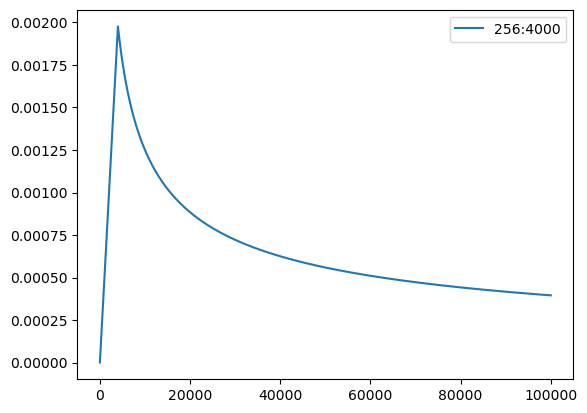

In [29]:
optimizer = NoamOpt(
    model_size=args.encoder_embed_dim, 
    factor=config.lr_factor, 
    warmup=config.lr_warmup, 
    optimizer=torch.optim.AdamW(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.0001))
plt.plot(np.arange(1, 100000), [optimizer.rate(i) for i in range(1, 100000)])
plt.legend([f"{optimizer.model_size}:{optimizer.warmup}"])
None

In [30]:
from fairseq.data import iterators
from torch.cuda.amp import GradScaler, autocast

def train_one_epoch(epoch_itr, model, task, criterion, optimizer, accum_steps=1):
    itr = epoch_itr.next_epoch_itr(shuffle=True)
    itr = iterators.GroupedIterator(itr, accum_steps) # gradient accumulation: update every accum_steps samples
    
    stats = {"loss": []}
    scaler = GradScaler() # automatic mixed precision (amp) 
    
    model.train()
    progress = tqdm.tqdm(itr, desc=f"train epoch {epoch_itr.epoch}", leave=False)
    for samples in progress:
        model.zero_grad()
        accum_loss = 0
        sample_size = 0
        # gradient accumulation: update every accum_steps samples
        for i, sample in enumerate(samples):
            if i == 1:
                # emptying the CUDA cache after the first step can reduce the chance of OOM
                torch.cuda.empty_cache()

            sample = utils.move_to_cuda(sample, device=device)
            target = sample["target"]
            sample_size_i = sample["ntokens"]
            sample_size += sample_size_i
            
            # mixed precision training
            with autocast():
                net_output = model.forward(**sample["net_input"])
                lprobs = F.log_softmax(net_output[0], -1)            
                loss = criterion(lprobs.view(-1, lprobs.size(-1)), target.view(-1))
                
                # logging
                accum_loss += loss.item()
                # back-prop
                scaler.scale(loss).backward()                
        
        scaler.unscale_(optimizer)
        optimizer.multiply_grads(1 / (sample_size or 1.0)) # (sample_size or 1.0) handles the case of a zero gradient
        gnorm = nn.utils.clip_grad_norm_(model.parameters(), config.clip_norm) # grad norm clipping prevents gradient exploding
        
        scaler.step(optimizer)
        scaler.update()
        
        # logging
        loss_print = accum_loss/sample_size
        stats["loss"].append(loss_print)
        progress.set_postfix(loss=loss_print)
        if config.use_wandb:
            wandb.log({
                "train/loss": loss_print,
                "train/grad_norm": gnorm.item(),
                "train/lr": optimizer.rate(),
                "train/sample_size": sample_size,
            })
        
    loss_print = np.mean(stats["loss"])
    logger.info(f"training loss: {loss_print:.4f}")
    return stats

## Validation

In [31]:
# fairseq's beam search generator
# given model and input seqeunce, produce translation hypotheses by beam search
sequence_generator = task.build_generator([model], config)

def decode(toks, dictionary):
    # convert from Tensor to human readable sentence
    s = dictionary.string(
        toks.int().cpu(),
        config.post_process,
    )
    return s if s else "<unk>"

def inference_step(sample, model):
    gen_out = sequence_generator.generate([model], sample)
    srcs = []
    hyps = []
    refs = []
    for i in range(len(gen_out)):
        # for each sample, collect the input, hypothesis and reference, later be used to calculate BLEU
        srcs.append(decode(
            utils.strip_pad(sample["net_input"]["src_tokens"][i], task.source_dictionary.pad()), 
            task.source_dictionary,
        ))
        hyps.append(decode(
            gen_out[i][0]["tokens"], # 0 indicates using the top hypothesis in beam
            task.target_dictionary,
        ))
        refs.append(decode(
            utils.strip_pad(sample["target"][i], task.target_dictionary.pad()), 
            task.target_dictionary,
        ))
    return srcs, hyps, refs

In [32]:
import shutil
import sacrebleu

def validate(model, task, criterion, log_to_wandb=True):
    logger.info('begin validation')
    itr = load_data_iterator(task, "valid", 1, config.max_tokens, config.num_workers).next_epoch_itr(shuffle=False)
    
    stats = {"loss":[], "bleu": 0, "srcs":[], "hyps":[], "refs":[]}
    srcs = []
    hyps = []
    refs = []
    
    model.eval()
    progress = tqdm.tqdm(itr, desc=f"validation", leave=False)
    with torch.no_grad():
        for i, sample in enumerate(progress):
            # validation loss
            sample = utils.move_to_cuda(sample, device=device)
            net_output = model.forward(**sample["net_input"])
            
            lprobs = F.log_softmax(net_output[0], -1)
            target = sample["target"]
            sample_size = sample["ntokens"]
            loss = criterion(lprobs.view(-1, lprobs.size(-1)), target.view(-1)) / sample_size
            progress.set_postfix(valid_loss=loss.item())
            stats["loss"].append(loss)
            
            # do inference
#             s, h, r = inference_step(sample, model)
#             srcs.extend(s)
#             hyps.extend(h)
#             refs.extend(r)
            
    tok = 'zh' if task.cfg.target_lang == 'zh' else '13a'
    stats["loss"] = torch.stack(stats["loss"]).mean().item()
#     stats["bleu"] = sacrebleu.corpus_bleu(hyps, [refs], tokenize=tok) # 計算BLEU score
#     stats["srcs"] = srcs
#     stats["hyps"] = hyps
#     stats["refs"] = refs
    
    if config.use_wandb and log_to_wandb:
        wandb.log({
            "valid/loss": stats["loss"],
            "valid/bleu": stats["bleu"].score,
        }, commit=False)
    
    showid = np.random.randint(len(hyps))
#     logger.info("example source: " + srcs[showid])
#     logger.info("example hypothesis: " + hyps[showid])
#     logger.info("example reference: " + refs[showid])
    
    # show bleu results
    logger.info(f"validation loss:\t{stats['loss']:.4f}")
#     logger.info(stats["bleu"].format())
    return stats

In [33]:
task.target_dictionary.pad()

1

## Save

In [34]:
def validate_and_save(model, task, criterion, optimizer, epoch, save=True):   
    stats = validate(model, task, criterion)
    bleu = stats['bleu']
    loss = stats['loss']
    if save:
        # save epoch checkpoints
        savedir = Path(config.savedir).absolute()
        savedir.mkdir(parents=True, exist_ok=True)
        
        check = {
            "model": model.state_dict(),
            "stats": {"bleu": bleu.score, "loss": loss},
            "optim": {"step": optimizer._step}
        }
        torch.save(check, savedir/f"checkpoint{epoch}.pt")
        shutil.copy(savedir/f"checkpoint{epoch}.pt", savedir/f"checkpoint_last.pt")
        logger.info(f"saved epoch checkpoint: {savedir}/checkpoint{epoch}.pt")
    
        # save epoch samples
        with open(savedir/f"samples{epoch}.{config.source_lang}-{config.target_lang}.txt", "w", encoding='utf-8') as f:
            for s, h in zip(stats["srcs"], stats["hyps"]):
                f.write(f"{s}\t{h}\n")

        # get best valid bleu    
        if getattr(validate_and_save, "best_bleu", 0) < bleu.score:
            validate_and_save.best_bleu = bleu.score
            torch.save(check, savedir/f"checkpoint_best.pt")
            
        del_file = savedir / f"checkpoint{epoch - config.keep_last_epochs}.pt"
        if del_file.exists():
            del_file.unlink()
    
    return stats

def try_load_checkpoint(model, optimizer=None, name=None):
    name = name if name else "checkpoint_last.pt"
    checkpath = Path(config.savedir)/name
    if checkpath.exists():
        check = torch.load(checkpath)
        model.load_state_dict(check["model"])
        stats = check["stats"]
        step = "unknown"
        if optimizer != None:
            optimizer._step = step = check["optim"]["step"]
        logger.info(f"loaded checkpoint {checkpath}: step={step} loss={stats['loss']} bleu={stats['bleu']}")
    else:
        logger.info(f"no checkpoints found at {checkpath}!")

## Main

In [35]:
model = model.to(device=device)
criterion = criterion.to(device=device)

In [36]:
# itr = load_data_iterator(task, "valid", 1, config.max_tokens, config.num_workers).next_epoch_itr(shuffle=False)
# for sample in itr:
#     print(sample)
#     sample = utils.move_to_cuda(sample, device=device)
#     sequence_generator.generate([model], sample)

In [37]:
logger.info("task: {}".format(task.__class__.__name__))
logger.info("encoder: {}".format(model.encoder.__class__.__name__))
logger.info("decoder: {}".format(model.decoder.__class__.__name__))
logger.info("criterion: {}".format(criterion.__class__.__name__))
logger.info("optimizer: {}".format(optimizer.__class__.__name__))
logger.info(
    "num. model params: {:,} (num. trained: {:,})".format(
        sum(p.numel() for p in model.parameters()),
        sum(p.numel() for p in model.parameters() if p.requires_grad),
    )
)
logger.info(f"max tokens per batch = {config.max_tokens}, accumulate steps = {config.accum_steps}")

2023-03-28 19:12:36 | INFO | hw5.seq2seq | task: TranslationTask
2023-03-28 19:12:36 | INFO | hw5.seq2seq | encoder: TransformerEncoder
2023-03-28 19:12:36 | INFO | hw5.seq2seq | decoder: TransformerDecoder
2023-03-28 19:12:36 | INFO | hw5.seq2seq | criterion: LabelSmoothedCrossEntropyCriterion
2023-03-28 19:12:36 | INFO | hw5.seq2seq | optimizer: NoamOpt
2023-03-28 19:12:36 | INFO | hw5.seq2seq | num. model params: 6,795,776 (num. trained: 6,795,776)
2023-03-28 19:12:36 | INFO | hw5.seq2seq | max tokens per batch = 16384, accumulate steps = 2


In [38]:
epoch_itr = load_data_iterator(task, "train", config.start_epoch, config.max_tokens, config.num_workers)
# try_load_checkpoint(model, optimizer, name=config.resume)
while epoch_itr.next_epoch_idx <= config.max_epoch:
    # train for one epoch
    train_one_epoch(epoch_itr, model, task, criterion, optimizer, config.accum_steps)
    stats = validate_and_save(model, task, criterion, optimizer, epoch=epoch_itr.epoch)
    logger.info("end of epoch {}".format(epoch_itr.epoch))    
    epoch_itr = load_data_iterator(task, "train", epoch_itr.next_epoch_idx, config.max_tokens, config.num_workers)

2023-03-28 19:12:36 | WARNING | fairseq.tasks.fairseq_task | 1 samples have invalid sizes and will be skipped, max_positions=(1024, 1024), first few sample ids=[326651]
2023-03-28 19:12:42 | INFO | fairseq.data.iterators | grouped total_num_itrs = 411


train epoch 1:   0%|          | 0/411 [00:00<?, ?it/s]

2023-03-28 19:20:23 | INFO | hw5.seq2seq | training loss: 7.6868
2023-03-28 19:20:23 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/12 [00:00<?, ?it/s]

ValueError: high <= 0